### Build TensorFlow Dataset

In [1]:
# !pip uninstall tensorflow -y
# !python3 -m venv .venv
# !source .venv/bin/activate
# !pip install tensorflow==2.15.0
# !pip install pandas pydicom scikit-learn seaborn nbformat

# # The cuXXX (CUDA) wheels are Linux-only, NVIDIA GPU-only
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121/

# Use the command from the PyTorch website for macOS!
# !pip install torch torchvision torchaudio

#### Set Parameters

In [2]:
# Set TensorFlow logging level to suppress warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import ast
import pydicom

#  Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Global configuration
INPUT_SHAPE = (224, 224, 1)  # (512, 512, 1)
TARGET_SIZE = INPUT_SHAPE[:2]

2025-06-12 11:34:01.188526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 11:34:01.188589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12 11:34:01.189639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
Num GPUs Available: 2
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
# Check PyTorch version and GPU availability
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
# Never use the cuXXX index for macOS!
# Use the official PyPI source, or the command from the PyTorch website.
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 2
Current device: 0
Device name: NVIDIA RTX 6000 Ada Generation


#### Helper Functions

These helper functions, stored in a separate file named `data_utils.py`, load and preprocess DICOM images and masks, parse dataset records, and build a TensorFlow dataset for multitask learning from a metadata CSV.

In [5]:
# DICOM Loader
def load_dicom_image(path_tensor):
    """
    Loads and normalizes a DICOM image from a byte string path
    Converts image pixel values to float32, scales them to [0, 1], and handles exceptions by returning a zero image.
    """
    path = path_tensor.decode('utf-8')  # Decode byte string to UTF-8
    try:
        ds = pydicom.dcmread(path)
        img = ds.pixel_array.astype(np.float32)
        img -= np.min(img)
        img /= (np.max(img) + 1e-6)  # normalize to [0,1]
    except Exception as e:
        print(f"[DICOM ERROR] {path}: {e}")
        img = np.zeros(TARGET_SIZE, dtype=np.float32)
    return img


# TensorFlow Wrappers
def tf_load_dicom(path):
    """
    loads a single full mammogram DICOM image using load_dicom_image.
    Ensures the image has shape (H, W, 1), resizes it to the target size, and returns it as a TensorFlow tensor.
    """
    img = tf.numpy_function(func=load_dicom_image, inp=[path], Tout=tf.float32)
    img.set_shape([None, None])  # initially 2D
    img = tf.expand_dims(img, axis=-1)  # [H, W, 1]
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, TARGET_SIZE)
    return img


def tf_load_multiple_dicom(paths):
    """
    Loads and combines multiple DICOM mask images (e.g., for multiple ROIs).
    Loads each mask, stacks them, and returns the pixel-wise union using tf.reduce_max.
    """
    def load_single(path):
        img = tf.numpy_function(load_dicom_image, [path], tf.float32)
        img.set_shape([None, None])
        img = tf.expand_dims(img, axis=-1)
        img.set_shape([None, None, 1])
        img = tf.image.resize(img, TARGET_SIZE)
        return img

    masks = tf.map_fn(
        load_single,
        paths,
        fn_output_signature=tf.TensorSpec(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1), dtype=tf.float32)
    )
    return tf.reduce_max(masks, axis=0)  # union of all masks


# Unified MTL Preprocessor for multitask learning (MTL)
def load_and_preprocess(image_path, mask_paths, label):
    """
    loads a single image, multiple mask images, and casts the label.
    Returns a tuple: (image, {"segmentation": mask, "classification": label}).
    """
    image = tf_load_dicom(image_path)
    mask = tf_load_multiple_dicom(mask_paths)
    label = tf.cast(label, tf.float32)
    return image, {"segmentation": mask, "classification": label}


def parse_record(record):
    """
    parses a dictionary record (with keys image_path, mask_paths, label) using load_and_preprocess.
    """
    image_path = record['image_path']
    mask_paths = record['mask_paths']
    label = record['label']
    image, target = load_and_preprocess(image_path, mask_paths, label)
    return image, target


# Builds a tf.data.Dataset from a metadata CSV file
def build_tf_dataset(
    metadata_csv: str,
    batch_size: int = 8,
    shuffle: bool = True
) -> tf.data.Dataset:
    """
    Reads and parses the CSV, converts mask path strings to lists, ensures correct label type, and creates a TensorFlow dataset of records.
    Applies the multitask mapping (parse_record), shuffles, batches, and prefetches.
    """
    # Load metadata CSV
    df = pd.read_csv(metadata_csv)
    # Parse stringified list of mask_paths
    df['mask_paths'] = df['mask_paths'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    # Ensure label column is float32-compatible (e.g., 0.0, 1.0)
    df['label'] = df['label'].astype(np.float32)
    # Convert to list of dicts
    records = df[['image_path', 'mask_paths', 'label']].to_dict(orient='records')
    # Create dataset
    ds = tf.data.Dataset.from_generator(
        lambda: (r for r in records),
        output_signature={
            "image_path": tf.TensorSpec(shape=(), dtype=tf.string),
            "mask_paths": tf.TensorSpec(shape=(None,), dtype=tf.string),
            "label": tf.TensorSpec(shape=(), dtype=tf.float32),
        }
    )
    # Apply MTL-compatible mapping function
    ds = ds.map(lambda r: parse_record(r), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(records))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


The resulting `ds` is a complete TensorFlow dataset of `(image, {"segmentation": mask, "classification": label})` tuples—normalized, resized, shuffled, batched, and ready for model training and validation.

### Develop a Baseline Sequential CNN Classification Model

Das et al. (2023) outline a flexible deep learning pipeline for breast cancer classification, featuring two main strategies: **Shallow CNN** and **Deep CNN**. Following their workflow, we first implement the shallow CNN approach as a baseline.

We develop a simple CNN model with an encoder and classification head, using only convolutional, pooling, and fully connected layers for binary (or multiclass) classification. This baseline allows us to objectively assess future model improvements.

The **Shallow CNN** path follows three incremental steps:

* 2 Conv Layers (baseline)
* 2 Conv Layers + Dropout
* 2 Conv Layers + Dropout + Data Augmentation

For each step, we use CBIS-DDSM dataset, apply standard preprocessing, and train the model, tuning hyperparameters as needed. Performance is evaluated with standard metrics, providing a foundation for deeper or more complex models in later experiments.

#### Set up Weights & Biases for experiment tracking

To make experiment tracking easier, we first install [Weights & Biases (wandb)](https://wandb.ai/) for experiment management and visualization. This tool allows us to log metrics, visualize model performance, and organize experiments efficiently.
```sh
pip install wandb
```
For first-time setup, we need to log in to wandb by pasting an API key when prompted:
```sh
wandb login
```

### Part 1: CNN with 2 Convolutional Layers (baseline)
  This baseline model consists of two convolutional layers followed by pooling, a dense layer, and an output layer. It serves as the simplest deep learning architecture in the pipeline and acts as a benchmark for evaluating further enhancements.

#### Configuration

In [6]:
import os
# Set TensorFlow logging level to suppress warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

INPUT_SHAPE = (224, 224, 1)
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
MODEL_DIR = "./models"
HISTORY_DIR = "../results/history"
PROJECT = "second_baseline_cnn_2_conv_layers"
LABELS = ["BENIGN", "MALIGNANT"]

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(HISTORY_DIR, exist_ok=True)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import wandb

# Ensure the models directory exists
import os
model_dir = os.path.abspath("../models")
os.makedirs(model_dir, exist_ok=True)


#### Build and compile a shallow CNN model as a baseline

A shallow convolutional neural network (CNN) model was constructed and compiled using an appropriate loss function and optimizer. The model was then trained on the dataset, with training progress monitored using a validation set. Key performance metrics—including accuracy and loss—were evaluated on the validation set to assess the model’s baseline performance.

In [8]:
from tensorflow.keras import layers, models

def build_shallow_cnn(input_shape=INPUT_SHAPE, num_classes=1):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])

#### Prepare Data and Split

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

metadata = pd.read_csv("../data/processed/cbis_ddsm_metadata_full.csv")

train_meta, val_meta = train_test_split(
    metadata, test_size=0.2, stratify=metadata['label'], random_state=42
)

train_meta.to_csv("../temporary/train_split.csv", index=False)
val_meta.to_csv("../temporary/val_split.csv", index=False)

#### Build TensorFlow Datasets

In [10]:
from data_utils import build_tf_dataset
import tensorflow as tf

train_ds = build_tf_dataset(metadata_csv="../temporary/train_split.csv", batch_size=BATCH_SIZE)
val_ds = build_tf_dataset(metadata_csv="../temporary/val_split.csv", batch_size=BATCH_SIZE)
train_ds = train_ds.map(lambda x, y: (x, y["classification"])).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (x, y["classification"])).prefetch(tf.data.AUTOTUNE)

#### Compile and Initialize the Model

In [11]:
import tensorflow as tf

model = build_shallow_cnn(INPUT_SHAPE)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

#### Initialize W&B and Callbacks

In [12]:
import wandb

wandb.init(project=PROJECT, config={
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "optimizer": "Adam",
    "learning_rate": LEARNING_RATE,
    "architecture": "shallow_cnn"
})

callbacks = [
    wandb.keras.WandbMetricsLogger(),
    wandb.keras.WandbModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, "best_model_epoch.keras"),
        monitor="val_loss", save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
]

wandb: Currently logged in as: tkshfj (tkshfj-bsc-computer-science-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


#### Train the Model

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
375/375 [==============================] - 396s 204ms/step - loss: 0.6695 - accuracy: 0.5807 - auc: 0.5889 - precision: 0.4849 - recall: 0.2856 - val_loss: 0.6467 - val_accuracy: 0.6205 - val_auc: 0.6639 - val_precision: 0.5462 - val_recall: 0.4595
Epoch 2/20
375/375 [==============================] - 392s 207ms/step - loss: 0.6167 - accuracy: 0.6433 - auc: 0.6988 - precision: 0.5870 - recall: 0.4531 - val_loss: 0.6459 - val_accuracy: 0.6085 - val_auc: 0.6884 - val_precision: 0.5169 - val_recall: 0.7443
Epoch 3/20
375/375 [==============================] - 393s 214ms/step - loss: 0.5741 - accuracy: 0.6817 - auc: 0.7565 - precision: 0.6447 - recall: 0.5065 - val_loss: 0.6040 - val_accuracy: 0.6591 - val_auc: 0.7109 - val_precision: 0.5904 - val_recall: 0.5599
Epoch 4/20
375/375 [==============================] - 390s 209ms/step - loss: 0.5282 - accuracy: 0.7223 - auc: 0.8065 - precision: 0.6977 - recall: 0.5752 - val_loss: 0.5970 - val_accuracy: 0.6565 - val_auc: 0.7221 - val

#### Save History

In [14]:
import pandas as pd
import pickle

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(HISTORY_DIR, "baseline-cnn-2-conv-layers.csv"), index=True)

with open(os.path.join(HISTORY_DIR, "baseline-cnn-2-conv-layers.pkl"), 'wb') as f:
    pickle.dump(history.history, f)

#### Plot Training Curves

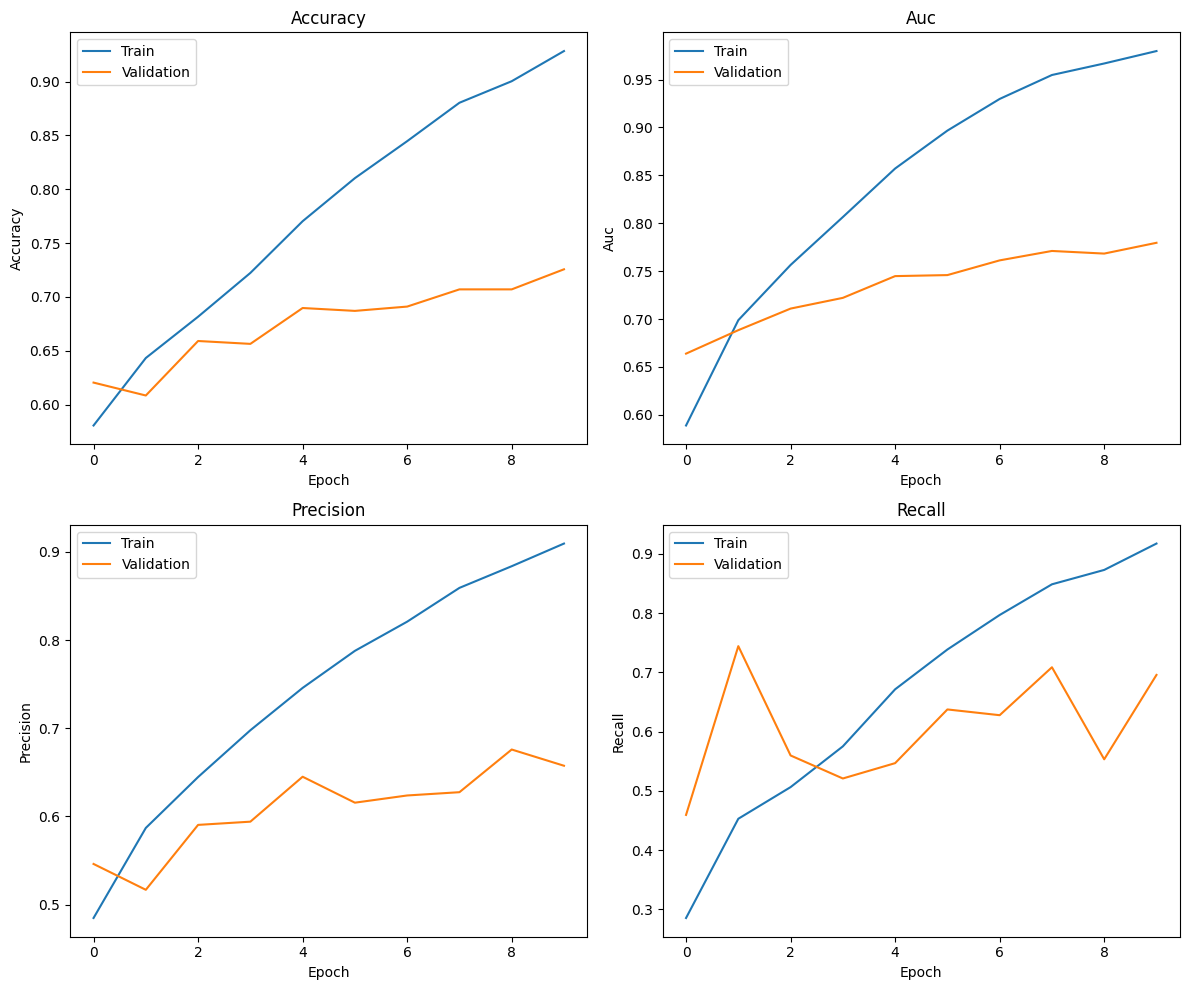

In [15]:
import matplotlib.pyplot as plt

def plot_history(history, metrics=('accuracy', 'auc', 'precision', 'recall')):
    plt.figure(figsize=(12, 10))
    for idx, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, idx)
        plt.plot(history[metric], label='Train')
        plt.plot(history['val_' + metric], label='Validation')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history.history)

#### Compute and Plot Confusion Matrix

24/24 [==============================] - 1s 8ms/step


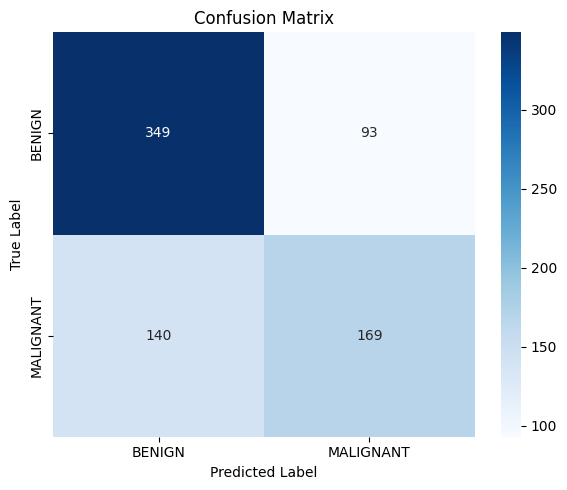

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Gather all validation data and labels
val_images, val_labels = [], []
for imgs, labels in val_ds:
    val_images.append(imgs.numpy())
    val_labels.append(labels.numpy())
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Model predictions
y_prob = model.predict(val_images)
y_pred = (y_prob > 0.5).astype(int).flatten()
y_true = val_labels.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

#### Save Model

In [17]:
model.save(os.path.join(MODEL_DIR, "baseline-cnn-2-conv-layers.keras"))
wandb.finish()

epoch/accuracy,▁▂▃▄▅▆▆▇▇█
epoch/auc,▁▃▄▅▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▅▄▃▂▂▁
epoch/precision,▁▃▄▅▅▆▇▇██
epoch/recall,▁▃▃▄▅▆▇▇██
epoch/val_accuracy,▂▁▄▄▆▆▆▇▇█
epoch/val_auc,▁▂▄▅▆▆▇▇▇█
epoch/val_loss,▇▇▃▃▁▃▂▆█▆
epoch/val_precision,▂▁▄▄▇▅▆▆█▇


### Part 2–3: CNN with Dropout & Data Augmentation

In this section, we **combine two regularization strategies** for our baseline CNN:

* **Dropout Layer:** Added after flattening, this layer randomly drops a fraction of features during training to help prevent overfitting.
* **Data Augmentation Pipeline:** Integrated as a preprocessing layer, leveraging TensorFlow’s built-in augmentation operations (random flip, rotation, zoom, translation) to increase data diversity.

**Key Implementation Details:**

* The **dropout rate** and **augmentation parameters** (rotation, zoom, translation) are exposed as hyperparameters.
* The entire model pipeline—including architecture, training, dropout, and augmentation—is implemented in a unified script (`train.py`), with all configuration handled via Weights & Biases (W\&B) sweeps.
* **All key hyperparameters**—including filter count, kernel size, dropout rate, batch size, learning rate, and augmentation strengths—are defined in `sweep.yaml` for systematic optimization.

**Benefits of the Combined Approach:**

* Enables robust evaluation of the impact of regularization and augmentation on model generalization.
* Supports automated, reproducible hyperparameter search with Bayesian optimization using W\&B sweeps.

**Summary:**
This improved codebase offers a modular and flexible setup where dropout and data augmentation are seamlessly integrated, supporting efficient experimentation and reproducibility.

To mitigate overfitting and improve the model’s ability to generalize, a Dropout layer is added after the dense layer. Dropout randomly deactivates a proportion of neurons during training, preventing the network from relying too heavily on specific features.

We use Weights and Biases Sweeps to automate hyperparameter search and model optimization. https://docs.wandb.ai/guides/sweeps/

#### Imports and Configuration

In [18]:
# import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# import wandb
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import EarlyStopping
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from data_utils import build_tf_dataset

# # Model input shape
# INPUT_SHAPE = (224, 224, 1)

#### Data Augmentation and Model Building Functions

In [19]:
# def build_data_augmentation(rotation=0.1, zoom=0.1, translation=0.1):
#     """Return a Sequential data augmentation pipeline."""
#     return tf.keras.Sequential([
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(rotation),
#         layers.RandomZoom(zoom),
#         layers.RandomTranslation(translation, translation)
#     ], name="data_augmentation")

# def build_model(input_shape, filters=32, kernel_size=3, dropout=0.3, 
#                 rotation=0.1, zoom=0.1, translation=0.1):
#     """Build a 2-layer CNN with data augmentation and dropout."""
#     data_augmentation = build_data_augmentation(rotation, zoom, translation)
#     return models.Sequential([
#         layers.Input(shape=input_shape),
#         data_augmentation,
#         layers.Conv2D(filters, kernel_size, activation='relu'),
#         layers.MaxPooling2D(2),
#         layers.Conv2D(filters * 2, kernel_size, activation='relu'),
#         layers.MaxPooling2D(2),
#         layers.Flatten(),
#         layers.Dropout(dropout),
#         layers.Dense(1, activation='sigmoid')
#     ])

#### Data Preparation

In [20]:
# # Load metadata and split
# metadata = pd.read_csv("../data/processed/cbis_ddsm_metadata_full.csv")
# train_meta, val_meta = train_test_split(
#     metadata, test_size=0.2, stratify=metadata['label'], random_state=42
# )

# # Optionally, save splits
# train_meta.to_csv("../temporary/train_split.csv", index=False)
# val_meta.to_csv("../temporary/val_split.csv", index=False)

# # Build TensorFlow datasets
# batch_size = 8  # Set your batch size here, or override with hyperparameter
# train_ds = build_tf_dataset(metadata_csv="../temporary/train_split.csv", batch_size=batch_size)
# val_ds = build_tf_dataset(metadata_csv="../temporary/val_split.csv", batch_size=batch_size)
# train_ds = train_ds.map(lambda x, y: (x, y["classification"])).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.map(lambda x, y: (x, y["classification"])).prefetch(tf.data.AUTOTUNE)

#### Model Initialization and Compilation

In [21]:
# # Example: set hyperparameters directly, or pull from sweep/config
# model = build_model(
#     input_shape=INPUT_SHAPE,
#     filters=32,
#     kernel_size=3,
#     dropout=0.3,
#     rotation=0.1,
#     zoom=0.1,
#     translation=0.1
# )

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss="binary_crossentropy",
#     metrics=[
#         "accuracy",
#         tf.keras.metrics.AUC(name="auc"),
#         tf.keras.metrics.Precision(name="precision"),
#         tf.keras.metrics.Recall(name="recall"),
#     ]
# )

#### W&B Initialization and Callbacks

In [22]:
# wandb.init(project="baseline_cnn_dropout_augmentation", config={
#     "filters": 32,
#     "kernel_size": 3,
#     "dropout": 0.3,
#     "batch_size": batch_size,
#     "learning_rate": 1e-4,
#     "rotation": 0.1,
#     "zoom": 0.1,
#     "translation": 0.1,
#     "epochs": 20
# })

# callbacks = [
#     wandb.keras.WandbMetricsLogger(),
#     EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
# ]

#### sweep.yaml

In [23]:
# program: train.py
# method: bayes
# metric:
#   name: val_auc
#   goal: maximize
# parameters:
#   learning_rate:
#     min: 0.00001
#     max: 0.001
#   batch_size:
#     values: [8, 16, 32]
#   filters:
#     values: [16, 32, 64]
#   kernel_size:
#     values: [3, 5]
#   dropout:
#     min: 0.0
#     max: 0.5
#   epochs:
#     value: 20
#   rotation:
#     min: 0.0
#     max: 0.2
#   zoom:
#     min: 0.0
#     max: 0.2
#   translation:
#     min: 0.0
#     max: 0.2

#### Training

In [24]:
# # sweep runs using wandb agent
# config = wandb.config

# model = build_model(
#     input_shape=INPUT_SHAPE,
#     filters=config.filters,
#     kernel_size=config.kernel_size,
#     dropout=config.dropout,
#     rotation=config.rotation,
#     zoom=config.zoom,
#     translation=config.translation
# )
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
#     loss="binary_crossentropy",
#     metrics=[
#         "accuracy",
#         tf.keras.metrics.AUC(name="auc"),
#         tf.keras.metrics.Precision(name="precision"),
#         tf.keras.metrics.Recall(name="recall"),
#     ]
# )

# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,  # Or use config['epochs']
#     callbacks=callbacks
# )

#### Save Model and End W&B Run

In [25]:
# model.save("./models/baseline_cnn_dropout_augmentation.keras")
# wandb.finish()

---

In [26]:
# import wandb
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import EarlyStopping
# import os

# # Build a CNN model with 2 convolutional layers and dropout
# def build_model(input_shape, filters=32, kernel_size=3, dropout=0.3):
#     model = models.Sequential([
#         layers.Conv2D(filters, kernel_size, activation='relu', input_shape=input_shape),
#         layers.MaxPooling2D(2),
#         layers.Conv2D(filters*2, kernel_size, activation='relu'),
#         layers.MaxPooling2D(2),
#         layers.Flatten(),
#         layers.Dropout(dropout),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     return model

# # Main training function
# def train():
#     # Initialize wandb
#     wandb.init(project="baseline_cnn_dropout_augmentation")
#     config = wandb.config

#     # Data loading
#     metadata = pd.read_csv("../data/processed/cbis_ddsm_metadata_full.csv")
#     # Split
#     train_meta, val_meta = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)
#     train_meta.to_csv("../temporary/train_split.csv", index=False)
#     val_meta.to_csv("../temporary/val_split.csv", index=False)
#     # Build datasets
#     train_ds = build_tf_dataset(metadata_csv="../temporary/train_split.csv", batch_size=8)
#     val_ds = build_tf_dataset(metadata_csv="../temporary/val_split.csv", batch_size=8)
#     train_ds = train_ds.map(lambda x, y: (x, y["classification"])).prefetch(tf.data.AUTOTUNE)
#     val_ds = val_ds.map(lambda x, y: (x, y["classification"])).prefetch(tf.data.AUTOTUNE)

#     # Build the model with sweep config values
#     model = build_model(
#         input_shape=(224, 224, 1),           # <-- replace with your true input shape
#         filters=config.filters,
#         kernel_size=config.kernel_size,
#         dropout=config.dropout
#     )

#     # Compile the model
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
#         loss="binary_crossentropy",
#         metrics=["accuracy", tf.keras.metrics.AUC(name="auc"),
#                  tf.keras.metrics.Precision(name="precision"),
#                  tf.keras.metrics.Recall(name="recall")]
#     )

#     # Train
#     model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=config.epochs,
#         batch_size=config.batch_size,
#         callbacks=[
#             wandb.keras.WandbMetricsLogger(),
#             EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
#         ],
#         verbose=2
#     )

# # Sweep configuration (as a Python dict, or save as sweep.yaml)
# sweep_config = {
#     "method": "bayes",  # or "random", "grid"
#     "metric": {"name": "val_auc", "goal": "maximize"},
#     "parameters": {
#         "learning_rate": {"min": 1e-5, "max": 1e-3},
#         "batch_size": {"values": [8, 16, 32]},
#         "filters": {"values": [16, 32, 64]},
#         "kernel_size": {"values": [3, 5]},
#         "dropout": {"min": 0.0, "max": 0.5},
#         "epochs": {"value": 20}
#     }
# }

# # Launch the sweep
# import wandb

# sweep_id = wandb.sweep(sweep_config, project="baseline_cnn_dropout_augmentation")
# wandb.agent(sweep_id, function=train)


### Analyze the results of the hyperparameter sweep

Download all runs from the project

In [27]:
# import wandb
# import pandas as pd

# # 1. Initialize API and get all runs for the project
# PROJECT = "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_augmentation"
# api = wandb.Api()
# runs = api.runs(PROJECT)

# print(f"Found {len(runs)} runs.")

# # 2. Build DataFrame with config and summary metrics
# records = []
# for run in runs:
#     row = dict(run.config)
#     for k, v in run.summary.items():
#         if not k.startswith('_'):
#             row[k] = v
#     row['run_id'] = run.id
#     row['run_name'] = run.name
#     records.append(row)

# df = pd.DataFrame(records)
# print(df.shape)
# df

Find the Best Run by Metric (e.g., epoch/val_auc)

In [28]:
# # 3. Find best run by 'epoch/val_auc'
# if 'epoch/val_auc' in df.columns:
#     best_idx = df['epoch/val_auc'].idxmax()
#     best_run = df.iloc[best_idx]
#     print("Best run name:", best_run['run_name'])
#     print("Best run ID:", best_run['run_id'])
#     print("Best run val_auc:", best_run['epoch/val_auc'])

#     # 4. Build URL
#     url = f"https://wandb.ai/{PROJECT}/runs/{best_run['run_id']}"
#     print("Best run URL:", url)
# else:
#     print("epoch/val_auc not found in DataFrame columns:", df.columns)

In [29]:
# import matplotlib.pyplot as plt
# # Get the best run's history for learning curve
# run = api.run(f"{PROJECT}/runs/{best_run['run_id']}")
# history = run.history()

# plt.figure()
# plt.plot(history['epoch/epoch'], history['epoch/val_auc'], label='Val AUC')
# plt.plot(history['epoch/epoch'], history['epoch/accuracy'], label='Train Acc')
# plt.xlabel("Epoch")
# plt.ylabel("Metric")
# plt.title(f"Learning Curve: {best_run['run_name']}")
# plt.legend()
# plt.show()

In [30]:
# print(history.columns)

#### Find the Best Runs

In [31]:
# best_run = df.sort_values("epoch/val_auc", ascending=False).iloc[0]
# print("Best run config:", best_run)

In [32]:
# best_idx = df['epoch/val_auc'].idxmax()
# best_run = df.iloc[best_idx]
# print(best_run)

#### Analyze Hyperparameter Trends

#### Automated Result Plotting: Hyperparameter vs. Metric

In [33]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.scatter(df['epoch/learning_rate'], df['epoch/val_auc'])
# plt.xlabel("Learning Rate")
# plt.ylabel("Validation AUC")
# plt.title("Learning Rate vs. Val AUC")
# plt.xscale("log")
# plt.show()


#### Parallel Coordinates Plot

In [34]:
# import pandas as pd
# from pandas.plotting import parallel_coordinates

# params = ['epoch/learning_rate', 'batch_size', 'filters', 'kernel_size', 'dropout']
# parallel_coordinates(df[params + ['epoch/val_auc']], class_column='epoch/val_auc')
# plt.title("Parallel Coordinates: Hyperparameters vs. Val AUC")
# plt.show()

#### Learning Curves (Best/All Runs)

In [35]:
# # Example: download and plot learning curves for the best run
# run = api.run("tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_augmentation/h6zl7pfq")
# history = run.history()
# plt.plot(history['epoch/epoch'], history['epoch/val_auc'], label='Val AUC')
# plt.plot(history['epoch/epoch'], history['epoch/accuracy'], label='Train Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.title("Learning Curves (Best Run)")
# plt.show()

### Part 3: CNN with 2 Conv Layers + Data Augmentation
  Building on Part 2, data augmentation techniques are introduced during the training phase. Methods such as random rotations, translations, zooms, and horizontal flips are applied to the input images, artificially increasing the diversity of the training set and further reducing the risk of overfitting.

We apply data augmentation to your data pipeline to enhance the model's robustness and generalization capabilities. This involves applying transformations such as random rotations, shifts, zooms, and flips to the training images, which helps the model learn invariant features and improves its performance on unseen data.

In [36]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Example of setting up data augmentation for training data
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # For validation/test, only rescale
# val_datagen = ImageDataGenerator(rescale=1./255)

# # Example:
# # train_generator = train_datagen.flow_from_directory(
# #     'data/train',
# #     target_size=(224, 224),
# #     batch_size=32,
# #     class_mode='categorical',  # or 'binary'
# #     color_mode='grayscale',    # if images are grayscale
# # )

# # Use the same model as Part 2 (with dropout)
# model = build_shallow_cnn_dropout(input_shape=INPUT_SHAPE, num_classes=2)
